In [1]:
import json
import matplotlib.pyplot as plt
import pandas as pd

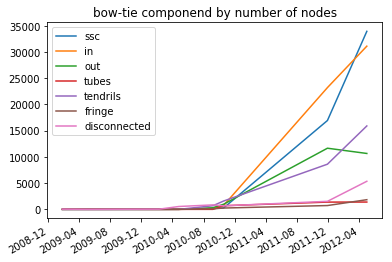

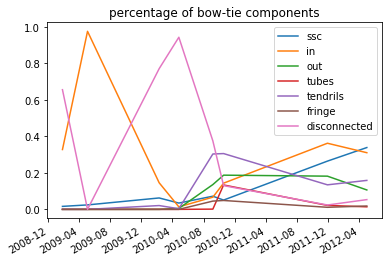

In [6]:
#plot results using the test.json

df = pd.read_json("test.json",convert_dates=True).transpose()
df = df.sort_index()

total_nodes = df["nodes"]
bt_components = ["ssc","in","out","tubes","tendrils","fringe","disconnected"]

#absolut number of nodes in compnents
df_comp = df.copy()[bt_components]
df_comp.plot(title="bow-tie componend by number of nodes")

#relative number of nodes in compnents
df_percent = df_comp.div(total_nodes.values,axis=0)
#df_percent.reset_index(drop=True).plot()
df_percent.plot(title="percentage of bow-tie components")

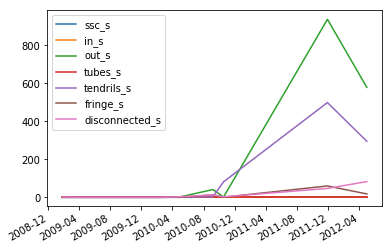

In [10]:
# plot is_sink per component absolute
df.copy()[list(map(lambda x: x +  "_s" ,bt_components))].plot(title = "number of sink?? in components")

In [3]:
with open('result.json', 'r', encoding='utf8', errors='ignore') as f:
    data = json.load(f)

In [4]:
ssc_lst = []
in_lst = []
out_lst = []
tubes_lst = []
tendrils_lst = []
fringe_lst = []
disconnected_lst = []

for key in data:
    ssc_lst.append(data[key]["ssc"])
    in_lst.append(data[key]["in"])
    out_lst.append(data[key]["out"])
    tubes_lst.append(data[key]["tubes"])
    tendrils_lst.append(data[key]["tendrils"])
    fringe_lst.append(data[key]["fringe"])
    disconnected_lst.append(data[key]["disconnected"])

In [11]:
disconnected_lst

[0.6557, 0.0, 0.7708, 0.9431, 0.3751, 0.1301, 0.0239, 0.0534]

[]

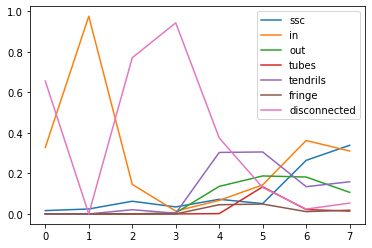

In [6]:
x = [i for i in range(len(ssc_lst))]

plt.plot(x, ssc_lst, label="ssc")
plt.plot(x, in_lst, label="in")
plt.plot(x, out_lst , label="out")
plt.plot(x, tubes_lst, label="tubes")
plt.plot(x, tendrils_lst , label="tendrils")
plt.plot(x,fringe_lst , label="fringe")
plt.plot(x, disconnected_lst, label="disconnected")

plt.legend()
plt.plot()